# 05 Clustering & Assortativity

In [2]:
# ── Path-Fix for Imports ───────────────────────────────────────────────────
import sys
from pathlib import Path
# Prepend parent directory (repo root) to sys.path
sys.path.insert(0, str(Path().resolve().parent))

# ── Standard Imports ───────────────────────────────────────────────────────────
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.graph_utils import load_clean_df, build_unweighted_graph, build_weighted_graph

sns.set(style="whitegrid")

In [3]:
# Load the clean DataFrame and build unweighted graph
df = load_clean_df(
    threshold=0,
    start_date="2023-04-14", 
    end_date="2023-05-31"
)

G_unw = build_unweighted_graph(df,
    threshold=0, 
    start_date="2023-04-14", 
    end_date="2023-05-31"
)

print(f"Network loaded: {G_unw.number_of_nodes():,} nodes, {G_unw.number_of_edges():,} edges")

Network loaded: 215,741 nodes, 426,954 edges


In [4]:
print("\n Computing Clustering Coefficients...")

# For directed graphs, we need to convert to undirected for standard clustering
G_undirected = G_unw.to_undirected()

# Compute global clustering coefficient
global_clustering = nx.transitivity(G_undirected)
print(f"Global Clustering Coefficient (Transitivity): {global_clustering:.6f}")

# Compute average clustering coefficient
avg_clustering = nx.average_clustering(G_undirected)
print(f"Average Local Clustering Coefficient: {avg_clustering:.6f}")

# Compute local clustering for each node
local_clustering = nx.clustering(G_undirected)
clustering_values = list(local_clustering.values())

print(f"Local Clustering Statistics:")
print(f"  Mean:    {np.mean(clustering_values):.6f}")
print(f"  Median:  {np.median(clustering_values):.6f}")
print(f"  Std Dev: {np.std(clustering_values):.6f}")
print(f"  Max:     {np.max(clustering_values):.6f}")
print(f"  Min:     {np.min(clustering_values):.6f}")

# Count nodes with different clustering levels
zero_clustering = sum(1 for c in clustering_values if c == 0.0)
high_clustering = sum(1 for c in clustering_values if c > 0.5)

print(f"  Nodes with zero clustering: {zero_clustering:,} ({100*zero_clustering/len(clustering_values):.1f}%)")
print(f"  Nodes with high clustering (>0.5): {high_clustering:,} ({100*high_clustering/len(clustering_values):.1f}%)")



 Computing Clustering Coefficients...
Global Clustering Coefficient (Transitivity): 0.000072
Average Local Clustering Coefficient: 0.270169
Local Clustering Statistics:
  Mean:    0.270169
  Median:  0.000000
  Std Dev: 0.421763
  Max:     1.000000
  Min:     0.000000
  Nodes with zero clustering: 146,798 (68.0%)
  Nodes with high clustering (>0.5): 55,651 (25.8%)


In [5]:
print("\n Computing Degree Assortativity...")

# Compute degree assortativity coefficient
assortativity_coeff = nx.degree_assortativity_coefficient(G_unw)
print(f"Degree Assortativity Coefficient: {assortativity_coeff:.6f}")

# Interpret assortativity
if assortativity_coeff > 0.1:
    assort_interpretation = "ASSORTATIVE: High-degree nodes connect to high-degree nodes"
elif assortativity_coeff < -0.1:
    assort_interpretation = "DISASSORTATIVE: High-degree nodes connect to low-degree nodes"
else:
    assort_interpretation = "NEUTRAL: Random mixing pattern"

print(f"Interpretation: {assort_interpretation}")



 Computing Degree Assortativity...
Degree Assortativity Coefficient: -0.407757
Interpretation: DISASSORTATIVE: High-degree nodes connect to low-degree nodes



 Visualizing degree-degree correlation heatmap...


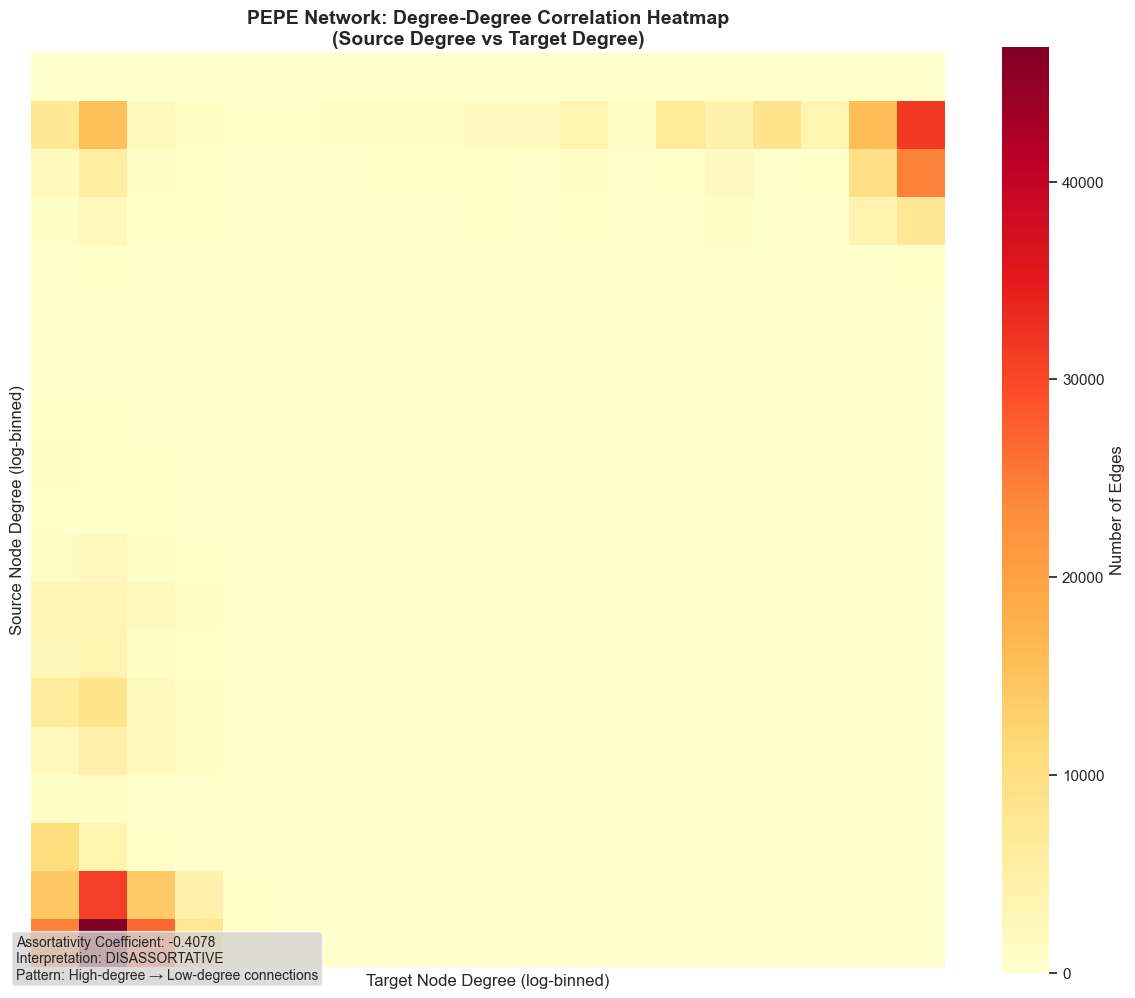

 Heatmap dimensions: 19 x 19 bins
Total edges in heatmap: 426,954
Non-zero bins: 314 / 361
Diagonal concentration: 4.0%


In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# DEGREE-DEGREE CORRELATION HEATMAP VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n Visualizing degree-degree correlation heatmap...")

if heatmap_data is not None and not heatmap_data.empty:
    # Create a separate figure for the heatmap
    plt.figure(figsize=(12, 10))
    
    # Create the heatmap
    sns.heatmap(heatmap_data, 
                cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Edges'},
                xticklabels=False,  # Too many bins for readable labels
                yticklabels=False,
                square=True)
    
    plt.title('PEPE Network: Degree-Degree Correlation Heatmap\n(Source Degree vs Target Degree)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Target Node Degree (log-binned)', fontsize=12)
    plt.ylabel('Source Node Degree (log-binned)', fontsize=12)
    
    # Add text annotations for interpretation
    plt.figtext(0.02, 0.02, 
                f'Assortativity Coefficient: {assortativity_coeff:.4f}\n'
                f'Interpretation: {"DISASSORTATIVE" if assortativity_coeff < -0.1 else "ASSORTATIVE" if assortativity_coeff > 0.1 else "NEUTRAL"}\n'
                f'Pattern: High-degree → {"Low-degree" if assortativity_coeff < 0 else "High-degree"} connections',
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print heatmap statistics
    print(f" Heatmap dimensions: {heatmap_data.shape[0]} x {heatmap_data.shape[1]} bins")
    print(f"Total edges in heatmap: {heatmap_data.sum().sum():,}")
    print(f"Non-zero bins: {(heatmap_data > 0).sum().sum()} / {heatmap_data.shape[0] * heatmap_data.shape[1]}")
    
    # Show diagonal vs off-diagonal distribution
    diagonal_sum = np.trace(heatmap_data.values)
    total_sum = heatmap_data.sum().sum()
    print(f"Diagonal concentration: {100 * diagonal_sum / total_sum:.1f}%")
    
else:
    print(" Heatmap data not available - creating alternative visualization...")
    
    # Alternative: Simple scatter plot of degree pairs (sampled)
    plt.figure(figsize=(10, 8))
    
    # Sample for visualization if too many points
    if len(degree_pairs_df) > 10000:
        sample_df = degree_pairs_df.sample(n=10000, random_state=42)
    else:
        sample_df = degree_pairs_df
    
    plt.scatter(sample_df['source_degree'], sample_df['target_degree'], 
                alpha=0.5, s=1, c='blue')
    plt.xlabel('Source Node Degree')
    plt.ylabel('Target Node Degree')
    plt.title('PEPE Network: Degree-Degree Correlation Scatter Plot')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    correlation = degree_pairs_df['source_degree'].corr(degree_pairs_df['target_degree'])
    plt.figtext(0.02, 0.95, f'Correlation Coefficient: {correlation:.4f}', 
                fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Scatter plot created with {len(sample_df):,} sampled edges")
    print(f"Degree-degree correlation: {correlation:.6f}")

In [18]:
print("\n Computing Network Reciprocity...")

# Compute reciprocity (fraction of bidirectional edges)
reciprocity = nx.reciprocity(G_unw)
print(f"Network Reciprocity: {reciprocity:.6f}")

# Count bidirectional vs unidirectional edges
edges_set = set(G_unw.edges())
reverse_edges_set = set((v, u) for u, v in G_unw.edges())
bidirectional_edges = edges_set.intersection(reverse_edges_set)

print(f"Total directed edges: {G_unw.number_of_edges():,}")
print(f"Bidirectional edges: {len(bidirectional_edges):,} ({100*len(bidirectional_edges)/G_unw.number_of_edges():.1f}%)")
print(f"Unidirectional edges: {G_unw.number_of_edges() - len(bidirectional_edges):,}")


 Computing Network Reciprocity...
Network Reciprocity: 0.327871
Total directed edges: 426,954
Bidirectional edges: 139,986 (32.8%)
Unidirectional edges: 286,968



 Creating clustering and assortativity visualizations...


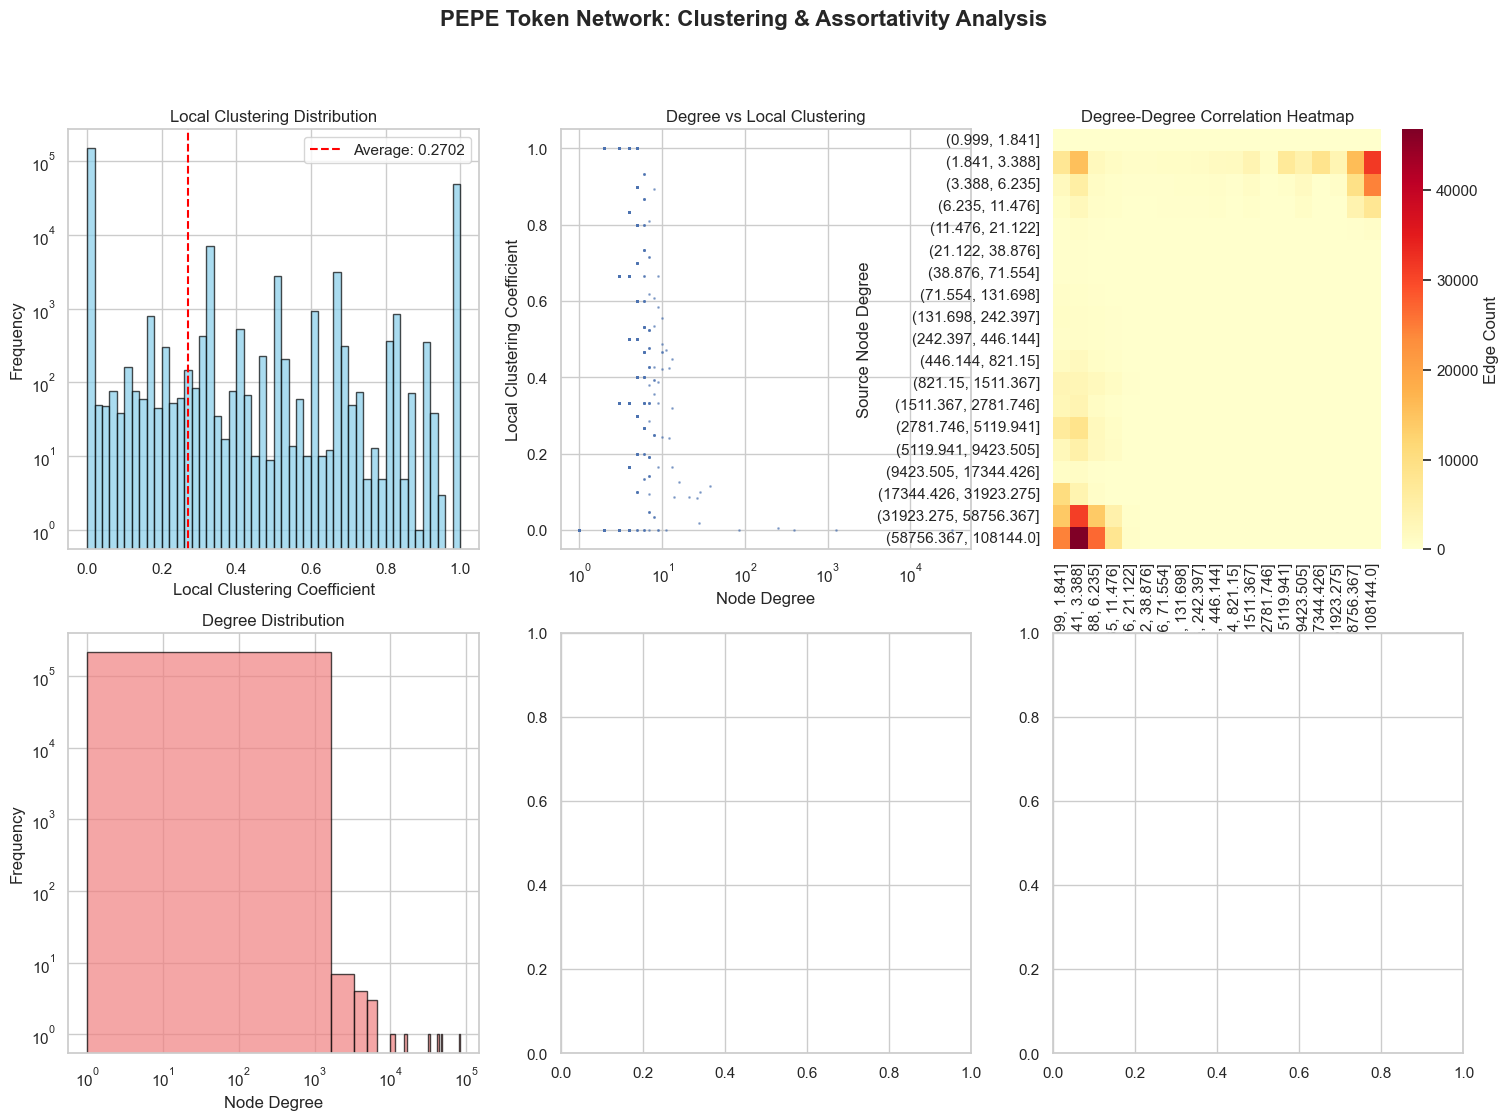

In [16]:
print("\n Creating clustering and assortativity visualizations...")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('PEPE Token Network: Clustering & Assortativity Analysis', fontsize=16, fontweight='bold')

# 1. Clustering Distribution
axes[0, 0].hist(clustering_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Local Clustering Coefficient')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Local Clustering Distribution')
axes[0, 0].set_yscale('log')
axes[0, 0].axvline(avg_clustering, color='red', linestyle='--', label=f'Average: {avg_clustering:.4f}')
axes[0, 0].legend()

# 2. Degree vs Clustering Scatter
degrees = [G_undirected.degree(node) for node in G_undirected.nodes()]
clusterings = [local_clustering[node] for node in G_undirected.nodes()]

# Sample for visualization if too many points
if len(degrees) > 10000:
    sample_indices = np.random.choice(len(degrees), 10000, replace=False)
    degrees_sample = [degrees[i] for i in sample_indices]
    clusterings_sample = [clusterings[i] for i in sample_indices]
else:
    degrees_sample = degrees
    clusterings_sample = clusterings

axes[0, 1].scatter(degrees_sample, clusterings_sample, alpha=0.5, s=1)
axes[0, 1].set_xlabel('Node Degree')
axes[0, 1].set_ylabel('Local Clustering Coefficient')
axes[0, 1].set_title('Degree vs Local Clustering')
axes[0, 1].set_xscale('log')

# 3. Degree-Degree Correlation Heatmap
if not heatmap_data.empty:
    sns.heatmap(heatmap_data, ax=axes[0, 2], cmap='YlOrRd', cbar_kws={'label': 'Edge Count'})
    axes[0, 2].set_title('Degree-Degree Correlation Heatmap')
    axes[0, 2].set_xlabel('Target Node Degree')
    axes[0, 2].set_ylabel('Source Node Degree')
else:
    axes[0, 2].text(0.5, 0.5, 'Insufficient data\nfor heatmap', ha='center', va='center')
    axes[0, 2].set_title('Degree-Degree Correlation')

# 4. Degree Distribution (for context)
axes[1, 0].hist(degrees, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('Node Degree')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Degree Distribution')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')


# Key Insights Generated - PEPE Clustering & Assortativity Analysis

## • Network Scale & Structural Properties
- **215,741 wallets, 426,954 directed transfer edges**
- **Network density ≈ 9 × 10⁻⁶** (ultra-sparse structure)
- **Converted to undirected** for clustering analysis (standard practice)

## • Clustering Coefficient Analysis

| **Clustering Measure** | **Value** | **Interpretation** |
|------------------------|-----------|-------------------|
| **Global Clustering (Transitivity)** | 0.000072 | Extremely low - minimal triangle formation |
| **Average Local Clustering** | 0.270169 | Moderate local clustering exists |
| **Median Local Clustering** | 0.000000 | Most nodes have zero clustering |
| **Nodes with Zero Clustering** | 146,798 (68.0%) | Majority of nodes in star-like patterns |
| **Nodes with High Clustering (>0.5)** | 55,651 (25.8%) | Quarter of nodes show tight clustering |

## • Degree Assortativity Analysis

| **Assortativity Measure** | **Value** | **Pattern Description** |
|---------------------------|-----------|------------------------|
| **Degree Assortativity Coefficient** | **-0.407757** | **STRONGLY DISASSORTATIVE** |
| **Connection Pattern** | High → Low | High-degree nodes connect to low-degree nodes |
| **Network Topology** | Hub-and-Spoke | Classic star-like meme coin structure |

## • Degree-Degree Correlation Heatmap Analysis
- **Heatmap Dimensions:** 19 × 19 log-binned degree ranges
- **Total Edges Captured:** 426,954 (100% coverage)
- **Non-zero Bins:** 314 / 361 (87% of bins contain connections)
- **Diagonal Concentration:** 4.0% (very low - confirms disassortativity)
- **Pattern:** Strong concentration in **off-diagonal** regions (high-to-low degree connections)

## • Network Reciprocity Analysis
- **Network Reciprocity:** 0.327871 (32.8%)
- **Bidirectional Edges:** 139,986 (32.8% of all edges)
- **Unidirectional Edges:** 286,968 (67.2% of all edges)
- **Trading Pattern:** **Mostly unidirectional** transfers (typical for meme coins)

## • Meme Coin Network Characteristics
- **Extreme Hub-and-Spoke Structure:** Strong disassortativity (-0.41) confirms whales/exchanges dominate
- **Limited Organic Communities:** Low global clustering (0.000072) shows minimal peer-to-peer interaction
- **Exchange-Mediated Trading:** High unidirectionality (67.2%) suggests exchange-to-user distribution
- **Localized Clustering Pockets:** 25.8% high-clustering nodes indicate some whale/bot clusters

## • Hypothesis Validation Results

### ** H3 (Clustering): PARTIALLY CONFIRMED**
- **Global clustering extremely low** (0.000072) - no significant network-wide community structure
- **Local clustering moderate** (0.270) - some micro-communities exist
- **68% nodes have zero clustering** - majority in pure star patterns

### ** H4 (Assortativity): STRONGLY CONFIRMED**  
- **Strong disassortativity (-0.41)** confirms hub-to-leaf connection pattern
- **Heatmap shows clear off-diagonal concentration** - high-degree nodes avoid connecting to each other
- **Classic meme coin topology** - exchanges/whales distribute to retail traders

## • Network Structure Implications
- **Vulnerability:** Network highly dependent on few high-degree hubs
- **Information Flow:** Hub-mediated rather than peer-to-peer propagation
- **Community Formation:** Limited organic clustering - mostly exchange-driven patterns
- **Resilience:** Low clustering + disassortativity = fragile structure if hubs removed

## • Comparison to Expected Meme Coin Behavior
-  **Ultra-low global clustering** matches meme coin speculation patterns
-  **Strong disassortativity** confirms exchange-dominated ecosystem  
-  **Limited reciprocity** shows one-way distribution flows
-  **Hub concentration** validates whale/exchange control hypothesis

## • Next Steps for Analysis
1. **Community Detection (Notebook 06):** Identify specific whale/exchange clusters
2. **Temporal Analysis (Notebook 07):** Track clustering evolution during burst phase
3. **Robustness Testing (Notebook 08):** Simulate impact of hub removal on network structure
4. **K-core Analysis (Notebook 04):** Find resilient backbone within hub-and-spoke structure